## Загрузим нужные библиотеки

In [1]:
import os
import numpy as np
import pandas as pd
import re

from ast import literal_eval

In [2]:
#import plotly.express as px

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(rc={'figure.figsize':(30,16)}) # Setting seaborn as default style even if use only matplotlib
sns.set(font_scale = 2)
sns.color_palette("dark", 8)

plt.rcParams['figure.figsize']=(30,16)

### Reproducibility block

In [3]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

In [4]:
def plot_hists_sns(inp_df, inp_feature):
    
    fig, axes = plt.subplots(4, 3, figsize=(30,30))
    
    sns.histplot(ax = axes[0, 0],
                data = inp_df,
                x = inp_feature,
                #hue = 'c2'
                )
    
    
#views
    tmp_df = inp_df.groupby([inp_feature]).views.agg(val_min='min', val_max='max', val_aver='mean')
    sns.barplot(ax = axes[1, 0],
               x = tmp_df.index,
               y = tmp_df.val_min.values,
                #hue = 'c2'
               )
    axes[1, 0].set_title(f'Histogram of minimum views over {inp_feature}')
    sns.barplot(ax = axes[1, 1],
               x = tmp_df.index,
               y = tmp_df.val_max.values,
                #hue = 'c2'
               )
    axes[1, 1].set_title(f'Histogram of maximum views over {inp_feature}')
    sns.barplot(ax = axes[1, 2],
               x = tmp_df.index,
               y = tmp_df.val_aver.values,
                #hue = 'c2'
               )
    axes[1, 2].set_title(f'Histogram of average views over {inp_feature}')
    
    
#depth
    tmp_df = inp_df.groupby([inp_feature]).depth.agg(val_min='min', val_max='max', val_aver='mean')
    sns.barplot(ax = axes[2, 0],
               x = tmp_df.index,
               y = tmp_df.val_min.values,
                #hue = 'c2'
               )
    axes[2, 0].set_title(f'Histogram of minimum depth over {inp_feature}')
    sns.barplot(ax = axes[2, 1],
               x = tmp_df.index,
               y = tmp_df.val_max.values,
                #hue = 'c2'
               )
    axes[2, 1].set_title(f'Histogram of maximum depth over {inp_feature}')
    sns.barplot(ax = axes[2, 2],
               x = tmp_df.index,
               y = tmp_df.val_aver.values,
                #hue = 'c2'
               )
    axes[2, 2].set_title(f'Histogram of average depth over {inp_feature}')
    
    
#full_reads_percent
    tmp_df = inp_df.groupby([inp_feature]).full_reads_percent.agg(val_min='min', val_max='max', val_aver='mean')
    sns.barplot(ax = axes[3, 0],
               x = tmp_df.index,
               y = tmp_df.val_min.values,
                #hue = 'c2'
               )
    axes[3, 0].set_title(f'Histogram of minimum full_reads_percent over {inp_feature}')
    sns.barplot(ax = axes[3, 1],
               x = tmp_df.index,
               y = tmp_df.val_max.values,
                #hue = 'c2'
               )
    axes[3, 1].set_title(f'Histogram of maximum full_reads_percent over {inp_feature}')
    sns.barplot(ax = axes[3, 2],
               x = tmp_df.index,
               y = tmp_df.val_aver.values,
                #hue = 'c2'
               )
    axes[3, 2].set_title(f'Histogram of aver full_reads_percent over {inp_feature}')
    
    fig.show()

In [5]:
def plot_corrc(inp_df, inp_cols, targ_cols = ['views', 'depth', 'full_reads_percent']):
    f, ax = plt.subplots(1, 2, figsize=(24, 8))
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(), 
    #sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(), 
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[0])
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(method = 'spearman'), 
    #sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(), 
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1])
#    sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(method = 'spearman'), 
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 0])
#    sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(method = 'spearman'), 
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 1])
    
    if 'distrib_brdr' in inp_df.columns:
        sns.pairplot(inp_df[inp_cols + targ_cols + ['distrib_brdr']], height = 16, 
                     hue = 'distrib_brdr', #palette = {"A": "C0", "B": "C1"}
                     #markers = ['x', 'o']
                    )
    else:
        sns.pairplot(inp_df[inp_cols + targ_cols], height = 16, 
                    )


Выполним загрузу датсета

In [6]:
DIR_DATA  = os.path.join(os.getcwd(), 'data')
#DIR_TRAIN = os.path.join(DIR_DATA, 'train')
#DIR_TEST  = os.path.join(DIR_DATA, 'test')
DIR_SUBM  = os.path.join(os.getcwd(), 'subm')

In [7]:
#df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_extended.csv')) #, index_col= 0)
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_extended.csv')) #, index_col= 0)

#df_test = pd.read_csv(os.path.join(DIR_DATA, 'test_extended.csv'))#, index_col= 0)
df_test = pd.read_csv(os.path.join(DIR_DATA, 'test_extended.csv'))#, index_col= 0)

In [8]:
df_train.columns

Index(['document_id', 'title', 'publish_date', 'session', 'authors', 'ctr',
       'category', 'tags', 'views', 'depth', 'full_reads_percent',
       'true_category', 'true_title', 'nimgs', 'overview', 'text_len',
       'two_articles'],
      dtype='object')

# Проанализируем датасет

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   document_id         7000 non-null   object 
 1   title               7000 non-null   object 
 2   publish_date        7000 non-null   object 
 3   session             7000 non-null   object 
 4   authors             7000 non-null   object 
 5   ctr                 7000 non-null   float64
 6   category            7000 non-null   object 
 7   tags                7000 non-null   object 
 8   views               7000 non-null   int64  
 9   depth               7000 non-null   float64
 10  full_reads_percent  7000 non-null   float64
 11  true_category       7000 non-null   object 
 12  true_title          7000 non-null   object 
 13  nimgs               7000 non-null   int64  
 14  overview            4816 non-null   object 
 15  text_len            7000 non-null   int64  
 16  two_ar

In [10]:
df_train.describe()

,ctr,views,depth,full_reads_percent,nimgs,text_len,two_articles
count,7000.000000,7.000000e+03,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,2.217779,3.035162e+04,1.104794,34.619633,0.099857,298.796857,0.065714
std,2.778085,9.547786e+04,0.065018,10.775901,1.060345,218.604217,0.247800
min,0.000000,6.500000e+01,1.016000,4.978000,0.000000,0.000000,0.000000
25%,0.000000,5.438250e+03,1.055000,27.516000,0.000000,197.000000,0.000000
50%,1.348500,1.196200e+04,1.082000,34.334500,0.000000,255.000000,0.000000
75%,3.598500,2.705300e+04,1.147000,41.366250,0.000000,330.000000,0.000000
max,39.877000,2.554204e+06,1.799000,267.623000,26.000000,4850.000000,1.000000


● **document id** - идентификатор    
● **title** - заголовок статьи   
● **publish_date** - время публикации   
● **session** - номер сессии   
● **authors** - код автора   
● **views** - количество просмотров   
● **depth** - объем прочитанного материала   
● **full_reads percent** - процент читателей полностью прочитавших статью   
● **ctr** - показатель кликабельности   
● **category** - категория статьи   
● **tags** - ключевые слова в статье   

In [11]:
df_train.shape, df_train.index.nunique()

((7000, 17), 7000)

## Targets

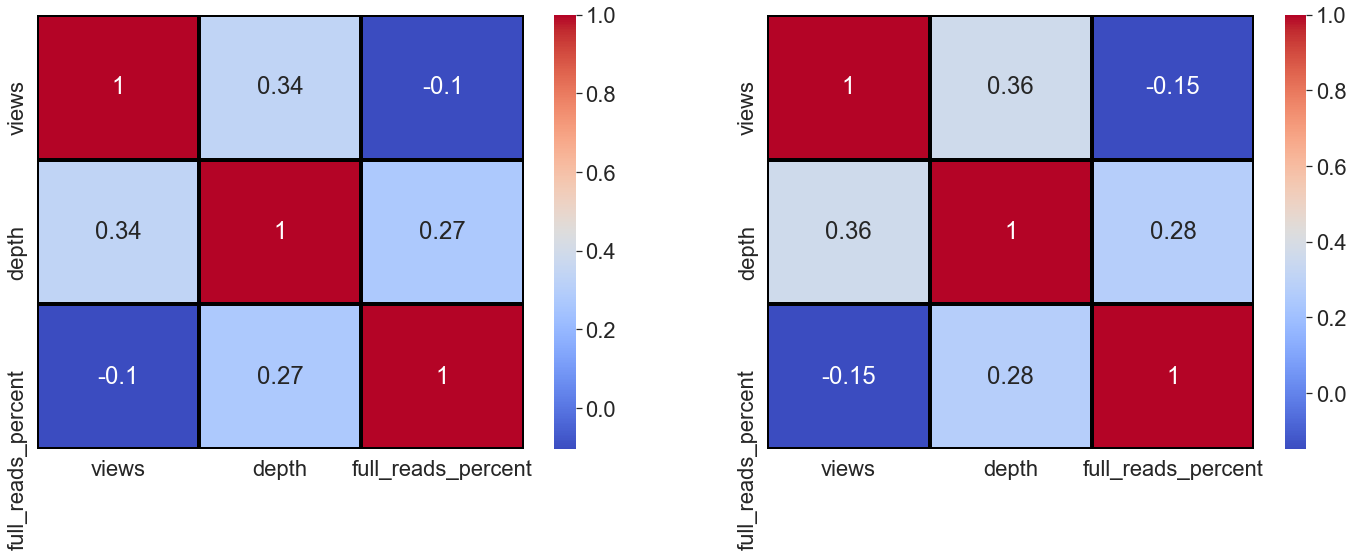

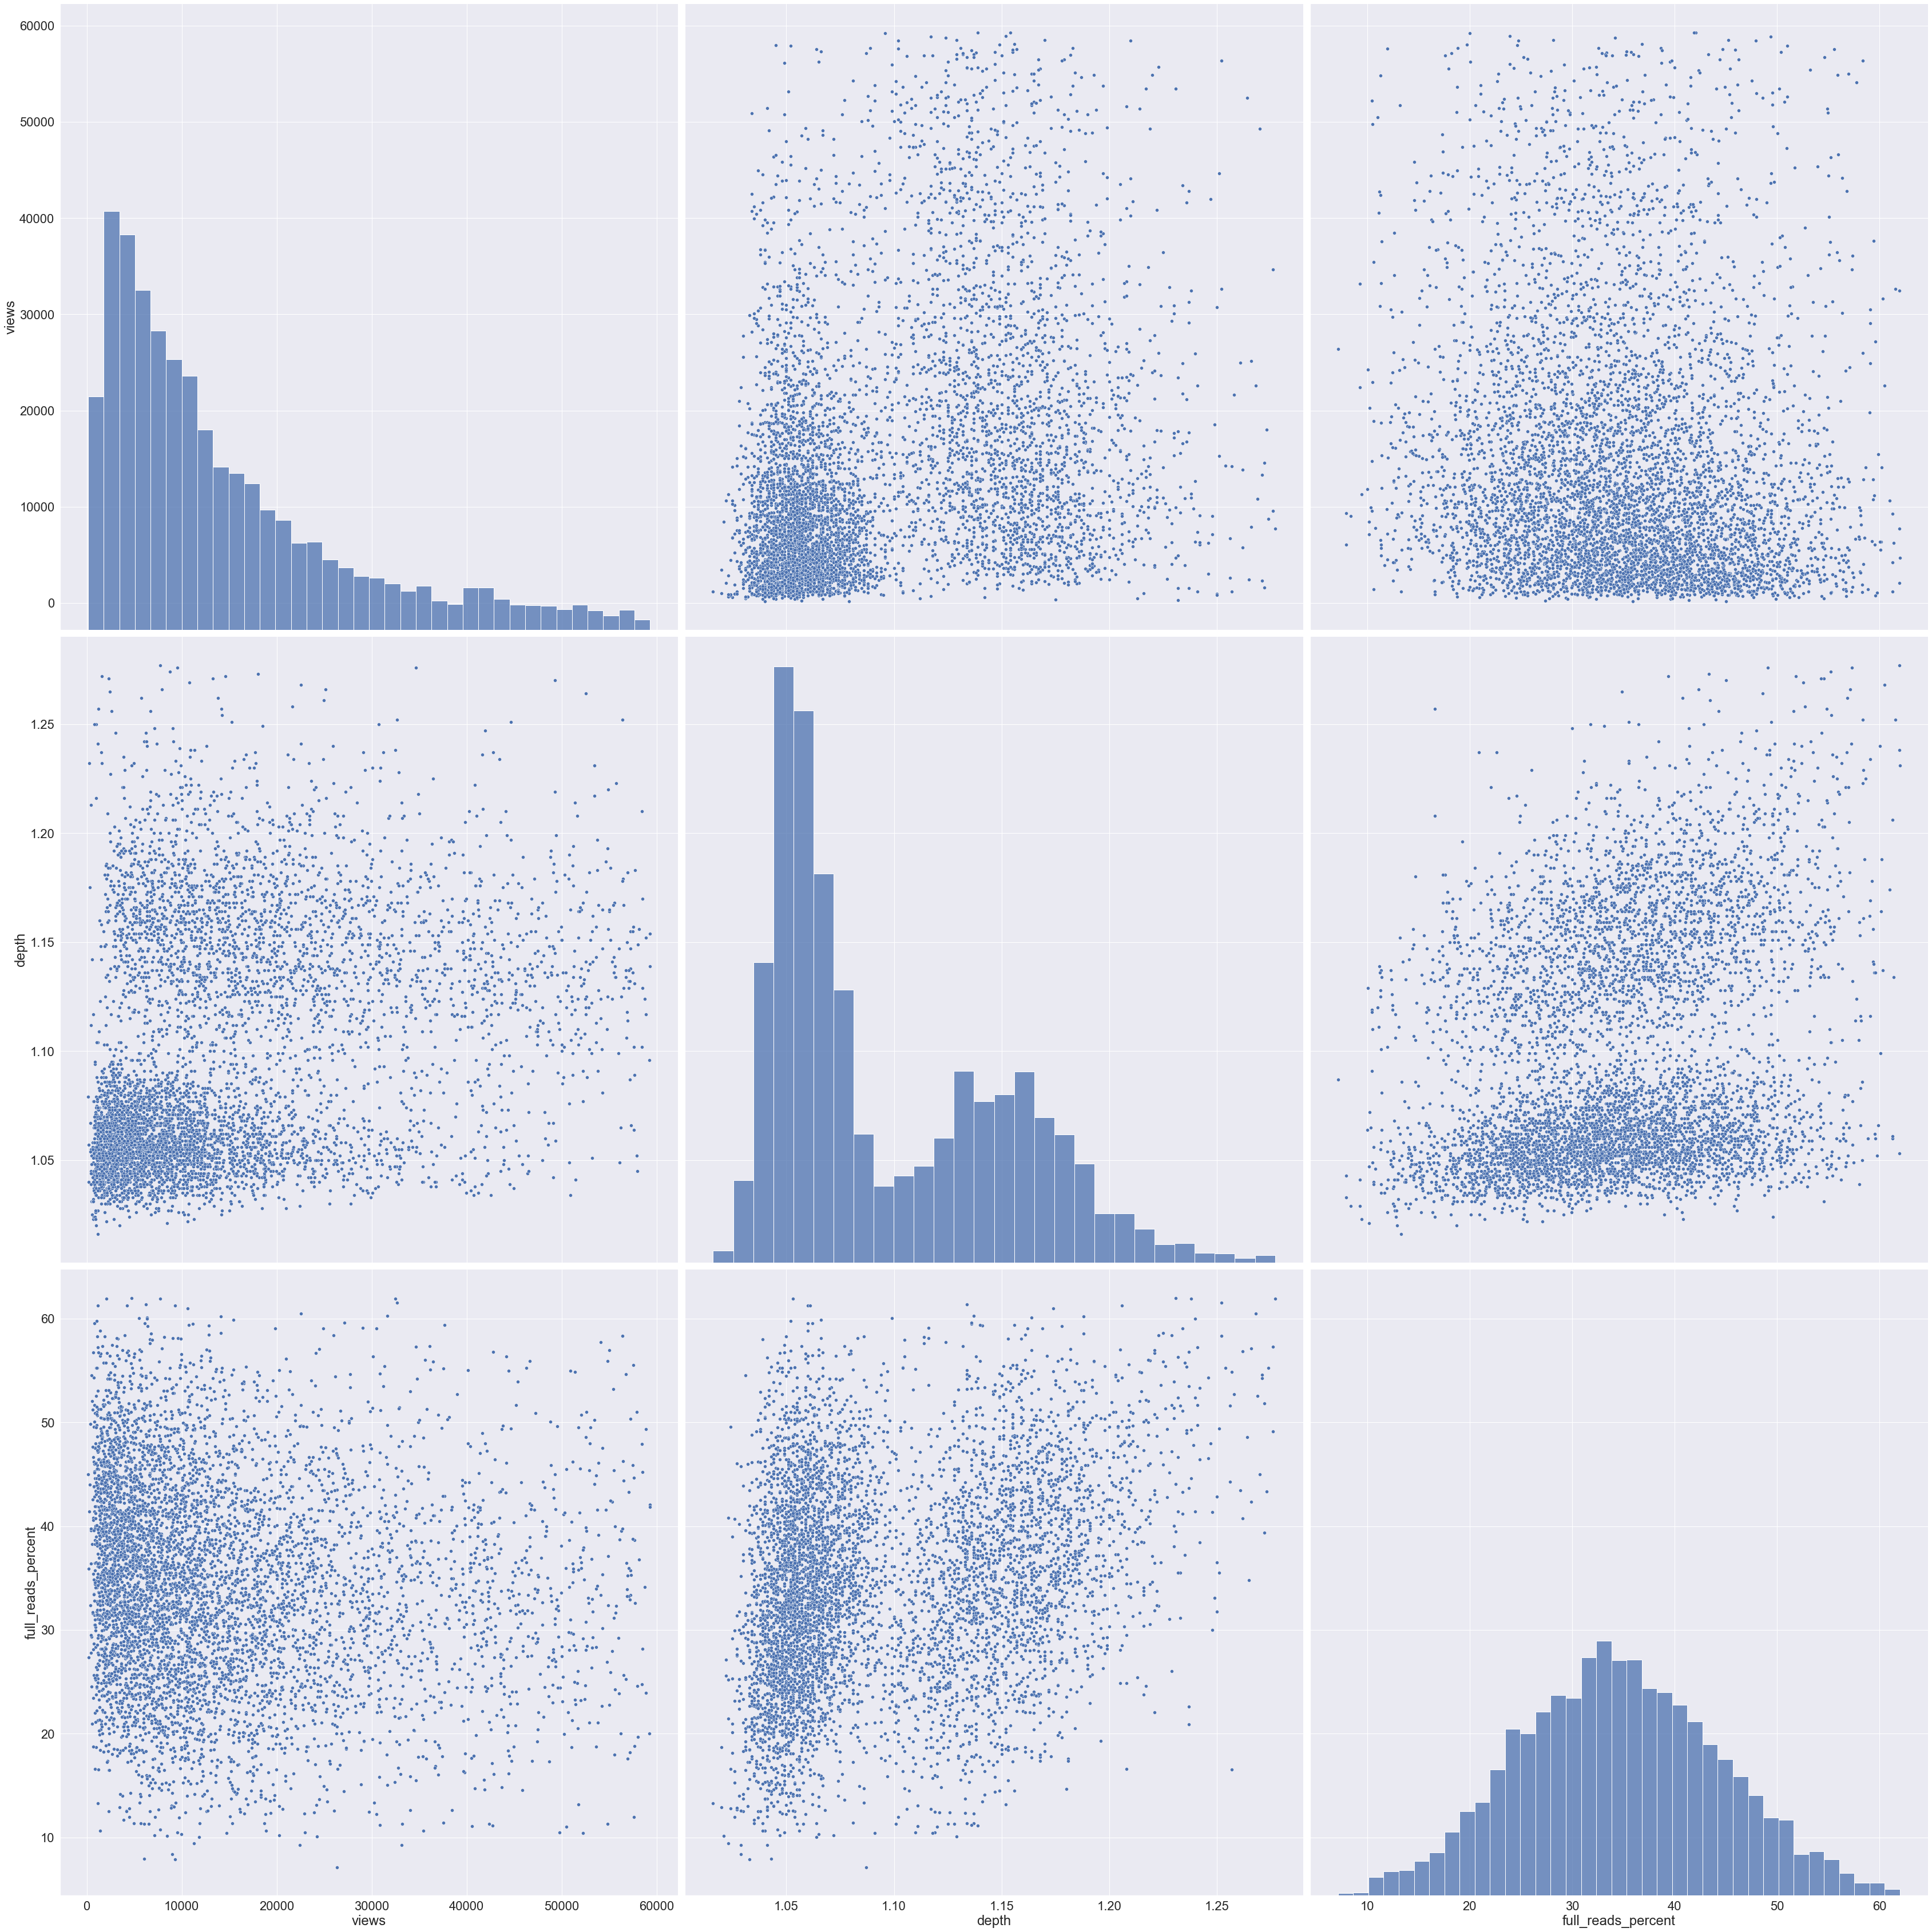

In [28]:
plot_corrc(df_train, ['views'], ['depth', 'full_reads_percent'])

In [13]:
Q1_v = df_train['views'].quantile(0.25)
Q3_v = df_train['views'].quantile(0.75)
IQR_v = Q3_v - Q1_v
print((Q3_v + 1.5 * IQR_v), df_train[df_train.views > (Q3_v + 1.5 * IQR_v)].shape)
print((Q3_v + 1.5 * IQR_v), df_train[df_train.views > (Q3_v + 1.75 * IQR_v)].shape)

Q1_d = df_train['depth'].quantile(0.25)
Q3_d = df_train['depth'].quantile(0.75)
IQR_d = Q3_d - Q1_d
print((Q3_d + 1.5 * IQR_d), df_train[df_train.depth > (Q3_d + 1.5 * IQR_d)].shape)

Q1_f = df_train['full_reads_percent'].quantile(0.25)
Q3_f = df_train['full_reads_percent'].quantile(0.75)
IQR_f = Q3_f - Q1_f
print((Q3_f + 1.5 * IQR_f), df_train[df_train.full_reads_percent > (Q3_f + 1.5 * IQR_f)].shape)

59475.125 (754, 17)
59475.125 (676, 17)
1.2850000000000001 (68, 17)
62.141625000000005 (32, 17)


Ожидаемо views может быть применено как фича для других таргетов.   
depth из состоит 2х распределений. необходимы 2 модели.    
между frp и двумя головами depth наглядно имеется корреляция.

данных мало. так что выкидывать много значений по iqr не факто вариант. но избавляться от выбросов точно стоит.   
пробую оба варианта

In [14]:
df_train.views.nlargest(10)

2424    2554204
4183    2554204
5086    2554204
5634    2554204
5951    2554204
6359    2554204
2438    2398050
3878     928192
5964     709143
3475     685067
Name: views, dtype: int64

In [15]:
df_train.iloc[[2438, 3878], :]

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent,true_category,true_title,nimgs,overview,text_len,two_articles
2438,623c56dc9a79473e9c1cd339JT2yahIJTDucJb8XxD9J2A,Чем Европа ответила на решение перевести оплат...,2022-03-24 18:10:59,JT2yahIJTDucJb8XxD9J2A,"['54215736cbb20f5cdfa7a8ce','613b3f049a7947536...",7.995,540d5eafcbb20f2524fc0509,"['5409f15de063daa0f408ada9', '5409f15de063daa0...",2398050,1.130,24.843,Война санкций,Чем Европа ответила на решение перевести оплат...,0,Россия перейдет с евро и доллара на рубли при ...,1197,0
3878,623b32609a794761bc20d5bbT_bSUOziTsSg1KF7unM_Kw,Зачем Россия решила перевести расчеты за газ в...,2022-03-23 19:07:15,T_bSUOziTsSg1KF7unM_Kw,"['54254690cbb20fa485b88cc9','619b93349a7947b51...",8.749,5409f11ce063da9c8b588a13,"['559291699a794751dc836a17', '542d2d97cbb20fc6...",928192,1.152,22.584,Война санкций,Зачем Россия решила перевести расчеты за газ в...,0,Россия переходит на рубли в расчетах за постав...,1427,0


2398050 и 928192 пока для меня выглядят выбросами. попробую как с нимси, так и без

In [16]:
df_train.depth.nlargest(10)

2424    1.799
4183    1.799
5086    1.799
5634    1.799
5951    1.799
6359    1.799
214     1.684
424     1.589
464     1.589
2090    1.589
Name: depth, dtype: float64

In [17]:
df_train.iloc[[214], :].title.values

array(['Как минимум 10 человек пострадали в результате стрельбы в Арканзасе\n                \n                                                    \n\n    \n\n    Общество,\xa006:46'],
      dtype=object)

странный заголовок для такого depth. для меня выглядит выбросом. уберу из обучающей выборки

In [18]:
#df_train.query('depth >= 1.3').shape

In [19]:
df_train.full_reads_percent.nlargest(6)
#df_train.full_reads_percent.nsmallest(10)

948     267.623
3603    217.550
205      75.729
126      67.897
6200     66.821
6445     66.630
Name: full_reads_percent, dtype: float64

In [20]:
df_train.iloc[[205], :].title.values

array(['Глава Минфина Украины заявил, что в стране не работает треть экономики'],
      dtype=object)

более 200 явно шум, даже если приставить, что их кодировали/преобразовывали. отбрасываем
75 тоже ваыглядит шумам на фоне остальных. стоит пробовать как с ним, так и без него   

In [21]:
df_train[df_train.ctr == 6.096][['title', 'ctr', 'text_len', 'views', 'depth', 'full_reads_percent']]

,title,ctr,text_len,views,depth,full_reads_percent
2424,Эскалация вокруг Украины. Что известно к 14:00,6.096,3191,2554204,1.799,4.978
4183,Байден попросил россиян не бояться США и НАТО....,6.096,3284,2554204,1.799,4.978
5086,Новое обострение ситуации вокруг Украины. Главное,6.096,3284,2554204,1.799,4.978
5634,ДНР и ЛНР объявили эвакуацию в Россию. Главное,6.096,3284,2554204,1.799,4.978
5951,Эскалация вокруг Украины. Что известно к 00:00,6.096,3284,2554204,1.799,4.978
6359,Россия возвращает военных с учений у границ. Г...,6.096,3284,2554204,1.799,4.978


In [22]:
df_train[df_train.text_len == 3284][['title', 'ctr', 'text_len', 'views', 'depth', 'full_reads_percent']]

,title,ctr,text_len,views,depth,full_reads_percent
4183,Байден попросил россиян не бояться США и НАТО....,6.096,3284,2554204,1.799,4.978
5086,Новое обострение ситуации вокруг Украины. Главное,6.096,3284,2554204,1.799,4.978
5634,ДНР и ЛНР объявили эвакуацию в Россию. Главное,6.096,3284,2554204,1.799,4.978
5951,Эскалация вокруг Украины. Что известно к 00:00,6.096,3284,2554204,1.799,4.978
6359,Россия возвращает военных с учений у границ. Г...,6.096,3284,2554204,1.799,4.978


In [23]:
df_test[df_test.ctr == 6.096][['title', 'ctr', 'text_len']]

,title,ctr,text_len
945,Новое обострение ситуации вокруг Украины. Главное,6.096,3191
1440,Новое обострение ситуации вокруг Украины. Главное,6.096,3191
2645,Эскалация вокруг Украины. Что известно к 03:00,6.096,3191


In [24]:
df_test[df_test.text_len == 3284][['title', 'ctr', 'text_len']]

,title,ctr,text_len


единственным критерием, объединяющий тему Украины является ctr. При этом views, depth и full_reads_percent одинаковы, выглядят выбросами.    
из обучения стоит убрать. в тесте в данных полях ставить константы.

# !!!! Для анализа без выбросов необходжимо запустить текущай блок. при анализе на выбросы его стоит пропустить

In [25]:
# только для трейна
def clear_data(inp_df: pd.DataFrame, min_time: pd.Timestamp) -> pd.DataFrame:
    
    exclude_category = {'5e54e2089a7947f63a801742', '552e430f9a79475dd957f8b3', '5e54e22a9a7947f560081ea2' }
    inp_df = inp_df.query('category not in @exclude_category')
    print(f'shape after clean category {inp_df.shape}')
    
    inp_df['publish_date'] = pd.to_datetime(inp_df['publish_date'])
    #inp_df = inp_df[inp_df.publish_date >= min_time]
    inp_df = inp_df.query('publish_date >= @min_time')
    print(f'shape after min time {inp_df.shape}')
    
    inp_df = inp_df.query('ctr != 6.096')
    print(f'shape after ctr {inp_df.shape}')
    
    if 'full_reads_percent' in inp_df.columns:
        inp_df = inp_df.query('full_reads_percent < 100')
        print(f'shape after frp time {inp_df.shape}')
                              
    
    return inp_df

In [26]:
def clean_by_irq(inp_df, min_time):
    
    exclude_category = {'5e54e2089a7947f63a801742', '552e430f9a79475dd957f8b3', '5e54e22a9a7947f560081ea2' }
    inp_df = inp_df.query('category not in @exclude_category')
    print(f'shape after clean category {inp_df.shape}')
    
    inp_df['publish_date'] = pd.to_datetime(inp_df['publish_date'])
    #inp_df = inp_df[inp_df.publish_date >= min_time]
    inp_df = inp_df.query('publish_date >= @min_time')
    print(f'shape after min time {inp_df.shape}')


    Q1_v = inp_df['views'].quantile(0.25)
    Q3_v = inp_df['views'].quantile(0.75)
    IQR_v = Q3_v - Q1_v
    Q1_d = inp_df['depth'].quantile(0.25)
    Q3_d = inp_df['depth'].quantile(0.75)
    IQR_d = Q3_d - Q1_d
    Q1_f = inp_df['full_reads_percent'].quantile(0.25)
    Q3_f = inp_df['full_reads_percent'].quantile(0.75)
    IQR_f = Q3_f - Q1_f
    
    inp_df = inp_df.query('(@Q1_v - 1.5 * @IQR_v) <= views <= (@Q3_v + 1.5 * @IQR_v)')
    inp_df = inp_df.query('(@Q1_d - 1.5 * @IQR_d) <= depth <= (@Q3_d + 1.5 * @IQR_d)')
    inp_df = inp_df.query('(@Q1_f - 1.5 * @IQR_f) <= full_reads_percent <= (@Q3_f + 1.5 * @IQR_f)')
    print(f'shape after irq {inp_df.shape}')
    
    return inp_df

In [27]:
min_test_time = pd.Timestamp('2022-01-01')
df_train = clean_by_irq(df_train, min_test_time)

shape after clean category (6997, 17)
shape after min time (6989, 17)
shape after irq (6163, 17)


C:\Users\_v010ch_\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Посмотрим на получившиеся iqr

интересно, что общее число не измеилось. проьую как с этими данными, так и без них

теперь посмотрим на таргеты вновь

In [ ]:
plot_corrc(df_train, ['views'], ['depth', 'full_reads_percent'])

# publish_date

In [ ]:
df_train['publish_date'] = pd.to_datetime(df_train['publish_date'])

df_train['m_d'] = df_train['publish_date'].dt.date

df_train['hour'] = df_train['publish_date'].dt.hour
df_train['dow'] = df_train['publish_date'].dt.dayofweek
#Monday=0, Sunday=6
df_train['weekend'] = (df_train.dow >= 4) # 5
#df_train['holidays']
df_train['day'] = pd.to_datetime(df_train['publish_date']).dt.strftime("%d").astype(int)
df_train['mounth'] = pd.to_datetime(df_train['publish_date']).dt.strftime("%m").astype(int)

df_train['distrib_brdr'] = df_train.m_d.apply(lambda x: 1 if x < border else 0)

In [ ]:
df_test['publish_date'] = pd.to_datetime(df_test['publish_date'])

проверим границы дат

In [ ]:
df_train['publish_date'].min(), df_test['publish_date'].min()

In [ ]:
df_train['publish_date'].max(), df_test['publish_date'].max()

In [ ]:
df_train[df_train.publish_date > df_test['publish_date'].min()].shape

In [ ]:
df_train[df_train.publish_date < df_test['publish_date'].min()].shape

In [ ]:
#df_train.sort_values(by='publish_date').head(15)

In [ ]:
#df_test.sort_values(by='publish_date').head(15)

в тесте скачек с 2021-10-04 на 2022-01-31 21:00:26. Далее даты идут регулярно.

всего 6 статей в трейне датой раньше, чем минимальная дата в тесте.   
далее скачек: 2021-05-17, 2021-09-17, 2021-12-17, 2021-12-17, 2022-01-29 06:00:22.   
в целом все даты 21 года выглядят оторванными, однако, могут находится в том же распределении, так что, вероятно, их стоит оставить.   
статьи из 17 и 18 гг, вероятно стоит исключить после проверки на наличия в них особенных авторов или тэгов.

In [ ]:
tmp = (df_train[df_train.publish_date > df_test['publish_date'].min()].sort_values('publish_date').groupby('m_d').agg('size'))
fig, ax = plt.subplots(1, 1, figsize = (30, 8))
sns.lineplot(y = tmp.values, x=tmp.keys(), ax = ax)

датасет хотелось бы увеличить, таких данных для добавления лагов недостаточно. однако непонятно откуда брать depth и frp   
виден недельный цикл в количестве статей

In [ ]:
#tmp = df_train[df_train.publish_date > df_test['publish_date'].min()].sort_values('publish_date').groupby('m_d').m_d.diff()
#sns.lineplot(y = tmp.values, x=tmp.keys())

In [ ]:
#min_time = pd.Timestamp('2022-01-01')
min_time = pd.Timestamp('2022-01-29')
tmp = df_train[df_train.publish_date > min_time][['publish_date', 'm_d']].sort_values('publish_date')['m_d'].drop_duplicates().diff()
tmp2 = df_train[df_train.publish_date > min_time][['publish_date', 'm_d']].sort_values('publish_date')['m_d'].drop_duplicates()

fig, ax = plt.subplots(1, 1, figsize = (30, 8))
sns.lineplot(x = tmp2.values, y = tmp.map(lambda x: x.days).values, ax = ax)

In [ ]:
tmp2.nunique(), tmp.map(lambda x: x.days).value_counts()

In [ ]:
low = pd.Timestamp('2022-02-21').date()
hi  = pd.Timestamp('2022-03-13').date()
df_train.query('m_d > @low and m_d < @hi').m_d.value_counts()

In [ ]:
def plot_means(inp_df: pd.DataFrame, inp_cat: str = 'all'):
    
    if inp_cat != 'all':
        tmp = inp_df[inp_df.category == inp_cat]
    else:
        tmp = inp_df
        
    tmp = (tmp.sort_values('publish_date').groupby('m_d')[['views', 'depth', 'full_reads_percent']].agg('mean'))
    tmp.reset_index(inplace = True)
    
    fig, ax = plt.subplots(3, 2, figsize=(30, 20))
    
    sns.lineplot(x = tmp.m_d, y = tmp['views'], ax = ax[0, 0])
    #ax[0, 0] = plt.axvline(border, 0, 40000)
    #plt.plot([border, border], [ 0, 40000])
    #sns.kdeplot(x = tmp.m_d, y = tmp['views'], ax = ax[0, 1])
    sns.kdeplot(x = tmp['views'], ax = ax[0, 1], bw_adjust = 0.3)
    
    sns.lineplot(x = tmp.m_d, y = tmp['depth'], ax = ax[1, 0])
    #sns.kdeplot(x = tmp.m_d, y = tmp['depth'], ax = ax[1, 1])
    sns.kdeplot(x = tmp['depth'], ax = ax[1, 1], bw_adjust = 0.3)
    
    sns.lineplot(x = tmp.m_d, y = tmp['full_reads_percent'], ax = ax[2, 0])
    #sns.kdeplot(x = tmp.m_d, y = tmp['full_reads_percent'], ax = ax[2, 1])
    sns.kdeplot(x = tmp['full_reads_percent'], ax = ax[2, 1], bw_adjust = 0.3)
    
    
    #plt.axvline(2.8, 0,0.17)

In [ ]:
df_train.category.unique()

In [ ]:
#min_time = pd.Timestamp('2022-01-01')
min_time = pd.Timestamp('2022-01-29')

In [ ]:
cat = '5433e5decbb20f277b20eca9' #'5409f11ce063da9c8b588a18' # 
border = pd.Timestamp('2022-04-08').date()
#plot_means(df_train.query('m_d > @hi'))
#plot_means(df_train[df_train.publish_date > min_time], '5433e5decbb20f277b20eca9')
#plot_means(df_train.query('publish_date > @min_time and m_d < @border'))
#plot_means(df_train.query('m_d > @border and category == @cat'))
plot_means(df_train.query('m_d > @border'))


In [ ]:
plot_hists_sns(df_train, 'dow')

In [ ]:
plot_hists_sns(df_train, 'hour')

In [ ]:
plot_hists_sns(df_train, 'day')

In [ ]:
plot_hists_sns(df_train, 'mounth')

In [ ]:
#plot_hists_sns(df_train, 'weekend')

In [ ]:
plot_corrc(df_train, ['hour', 'dow', 'day', 'mounth'],['views', 'depth', 'full_reads_percent']) #'weekend', 
#plot_corrc(df_train.query('m_d > @border'), ['hour', 'dow', 'day', 'mounth'],['views', 'depth', 'full_reads_percent']) #'weekend', 

In [ ]:
df_train.category.unique()

In [ ]:
Z_day = pd.Timestamp('2022-02-23').date()

In [ ]:
#plot_corrc(df_train[df_train.publish_date < Z_day], ['views'], ['depth', 'full_reads_percent'])
#plot_corrc(df_train[df_train.category == '5433e5decbb20f277b20eca9'], ['views'], ['depth', 'full_reads_percent'])

In [ ]:
#cat = ['5409f11ce063da9c8b588a18', '5409f11ce063da9c8b588a12','5433e5decbb20f277b20eca9', '540d5ecacbb20f2524fc050a', '540d5eafcbb20f2524fc0509', '5409f11ce063da9c8b588a13']
#df_train.query('publish_date <= @Z_day and category == @cat[1]').depth.hist(bins = 40)

In [ ]:
(df_train.m_d[0] - Z_day).days

In [ ]:
df_train['days_drom_z'] = df_train.m_d.apply()

# category

In [ ]:
df_train.category.nunique(), df_train.category.unique(), 

In [ ]:
plot_hists_sns(df_train, 'category')

In [ ]:
df_train.category.value_counts()

In [ ]:
df_test.category.value_counts()

вероятно стоит удалить последние 3 категории, что бы модель не переобучалась на них. к тому же их нет в тесте

In [ ]:
exclude_category = {'5e54e2089a7947f63a801742', '552e430f9a79475dd957f8b3', '5e54e22a9a7947f560081ea2' }
#plot_hists_sns(df_train.query('category in @exclude_category'), 'category')

In [ ]:
category_decode = {
    '5409f11ce063da9c8b588a12':{'name': 'Политика',      # / rbcfreenews
                                'link': 'politics',      # слово в ссылкена рбк
                                'last_word': 'Политика', # возможное последнее слово в title
                                                         # при наличии ошибки
                                },
    '5433e5decbb20f277b20eca9':{'name': 'Общество',      # / photoreport
                                'link': 'society',       # слово в ссылкена рбк
                                'last_word': 'Общество', # возможное последнее слово в title
                                                         # при наличии ошибки
                                },
    '540d5eafcbb20f2524fc0509':{'name': 'Бизнес',        # / rbcfreenews
                                'link': 'business',      # слово в ссылкена рбк
                                'last_word': 'Бизнес',   # возможное последнее слово в title
                                                         # при наличии ошибки
                                },
    '5409f11ce063da9c8b588a13':{'name': 'Экономка',      # / rbcfreenews
                                'link': 'economics',     # слово в ссылкена рбк
                                'last_word': 'Экономика', # возможное последнее слово в title
                                                         # при наличии ошибки
                                },
    '540d5ecacbb20f2524fc050a':{'name': 'Технологии и медия',# / rbcfreenews
                                'link': 'technology_and_media',      # слово в ссылкена рбк
                                'last_word': 'медиа',    # возможное последнее слово в title
                                                         # при наличии ошибки
                                },
    '5409f11ce063da9c8b588a18':{'name': 'Финансы',       # / rbcfreenews
                                'link': 'finances',      # слово вссылкена рбк
                                'last_word': 'Финансы',  # возможное последнее слово в title
                                                         # при наличии ошибки
                                },   

## DELETED????
        '5e54e2089a7947f63a801742':{'name': 'Политика',  # / rbcfreenews
                                'link': 'politics',      # слово вссылкена рбк
                                'last_word': 'Политика', # возможное последнее слово в title
                                                         # при наличии ошибки
                                },  
        '552e430f9a79475dd957f8b3':{'name': 'Деньги',    # / rbcfreenews
                                'link': 'money',         # слово вссылкена рбк
                                'last_word': 'Деньги',   # возможное последнее слово в title
                                                         # при наличии ошибки
                                },  
        '5e54e22a9a7947f560081ea2':{'name': 'Недвижимость',# / city
                                'link': 'realty',          # слово вссылкена рбк
                                'last_word': 'Недвижимость',  # возможное последнее слово в title
                                                           # при наличии ошибки
                                },  
}

In [ ]:
df_train[df_train.category == '5e54e22a9a7947f560081ea2'][['document_id', 'publish_date', 'title']]#.sample(5)

In [ ]:
df_train.iloc[4297].title

In [ ]:
# 'Захарова предложила Евросоюзу «отменить себя»\n                \n                                                    \n\n    \n\n    Политика,\xa012:28'

In [ ]:
#clean_text = lambda x:' '.join(re.sub('\n|\r|\t|[^а-я]', ' ', x.lower()).split())
clean_text = lambda x:' '.join(re.sub('\n|\r|\t|[^а-яА-ЯA-zA-Z]', ' ', x).split())

In [ ]:
tmp_ttl = 'Захарова предложила Евросоюзу «отменить себя»\n                \n                                                    \n\n    \n\n    Политика,\xa012:28'

In [ ]:
def clean_title(inp_val):
    
    #print(type(inp_df), inp_df.shape)
    len_before = len(inp_val)
    inp_val = clean_text(inp_val)
    
    if len(inp_val) - len_before > 50:
        if inp_val.split()[-1] in {'янв','фев','мар','апр','май','мая','июн','июл','авг','сен','окт','ноя','дек'}:
            inp_val = ' '.join(inp_val.split()[:-1])
            
        
    if inp_val.split()[-1] in {'Город', 'Общество', 'Политика', 'Финансы', 'Экономика', 'Бизнес'}:
        inp_val = ' '.join(inp_val.split()[:-1])
    
    if inp_val.split()[-1] == 'медиа' or inp_val.split()[-1] == 'медия':
        inp_val = ' '.join(inp_val.split()[:-3])
    
    if inp_val.split()[-1] == 'клуб':
        inp_val = ' '.join(inp_val.split()[:-2])
    
            
    return inp_val

In [ ]:
df_train['title_len_diff'] = df_train.title.apply(lambda x: len(x) - len(clean_text(x)))
df_test['title_len_diff']  = df_test.title.apply(lambda x: len(x) - len(clean_text(x)))

In [ ]:
df_train[['document_id', 'category', 'title', 'title_len_diff']].apply(find_cat_collisions, axis = 1)

In [ ]:
df_train[df_train.title_len_diff > 50].title.sample(10).values

In [ ]:
# 'Власти Москвы рассказали о ходе работ на Рублево-Архангельской линии\n                \n                                                    \n\n    \n\n    Город,\xa012:03',

In [ ]:
df_test[df_test.title_len_diff > 50].title.sample(10).values

# authors

In [ ]:
df_train['authors']  = df_train.authors.apply(lambda x: literal_eval(x))
df_train['Nauthors'] = df_train.authors.apply(lambda x: len(x))

df_test['authors']  = df_test.authors.apply(lambda x: literal_eval(x))
df_test['Nauthors'] = df_test.authors.apply(lambda x: len(x))

In [ ]:
df_train['Nauthors'].value_counts()

In [ ]:
df_test['Nauthors'].value_counts()

In [ ]:
#df_train[df_train.Nauthors >= 4].depth.hist(bins = 40)

удивительно, что возможные значения количества авторов в трейне и тесте совпадают. можно использовать как признак  
однако значения при > 3 малы, что может привести к переобучению

In [ ]:
plot_hists_sns(df_train, 'Nauthors')

In [ ]:
df_train['Nauthors_upd'] = df_train['Nauthors'].apply(lambda x: x if x < 4 else 4) # 3

In [ ]:
df_train['Nauthors_upd'].value_counts()

In [ ]:
plot_hists_sns(df_train, 'Nauthors_upd')

In [ ]:
all_authors = set()
for el in df_train.authors.values:
    if len (el) == 0:
        continue
    if len(el) == 1:
        all_authors.add(el[0])
        continue
        
    for author in el:
        all_authors.add(author)

In [ ]:
len(all_authors)

In [ ]:
all_authors_test = set()
for el in df_test.authors.values:
    if len (el) == 0:
        continue
    if len(el) == 1:
        all_authors_test.add(el[0])
        continue
        
    for author in el:
        all_authors_test.add(author)

In [ ]:
len(all_authors_test)

In [ ]:
missed_authors = set()
for el in all_authors_test:
    if el not in all_authors:
        missed_authors.add(el)

In [ ]:
len(missed_authors)

только 2 (2%) автора не представленны в обучающей выборке

In [ ]:
plot_corrc(df_train, ['Nauthors'], ['views', 'depth', 'full_reads_percent'])

## tags

In [ ]:
df_train['tags']  = df_train.tags.apply(lambda x: literal_eval(x))
df_train['Ntags'] = df_train.tags.apply(lambda x: len(x))

df_test['tags']  = df_test.tags.apply(lambda x: literal_eval(x))
df_test['Ntags'] = df_test.tags.apply(lambda x: len(x))

In [ ]:
df_train.Ntags.value_counts()

In [ ]:
df_test.Ntags.value_counts()

в тест есть статьи с большим количеством тэгов чем в трейне. хоть их количество и мало

In [ ]:
plot_hists_sns(df_train, 'Ntags')

In [ ]:
all_tags = set()
for el in df_train.tags.values:
    if len (el) == 0:
        continue
    if len(el) == 1:
        all_tags.add(el[0])
        continue
        
    for tag in el:
        all_tags.add(tag)

In [ ]:
len(all_tags)

In [ ]:
all_tags_test = set()
for el in df_test.tags.values:
    if len (el) == 0:
        continue
    if len(el) == 1:
        all_tags_test.add(el[0])
        continue
        
    for tag in el:
        all_tags_test.add(tag)

In [ ]:
len(all_tags_test)

In [ ]:
missed_tags = set()
for el in all_tags_test:
    if el not in all_tags:
        missed_tags.add(el)


In [ ]:
len(missed_tags)

1149 (17%) тэгов не представлены в обучающей выборке!!!!!

## ctr

In [ ]:
df_train.hist('ctr', bins = 80, figsize=(24, 8))

In [ ]:
(df_train.ctr == 0).sum()

In [ ]:
df_train.ctr.min(), df_train.ctr.max()

In [ ]:
#df_train['crt_bins'] = df_train.crt.

In [ ]:
plot_corrc(df_train, ['ctr'], ['views', 'depth', 'full_reads_percent'])

In [ ]:
bins = [-0.25 + 0.5*el for el in range(30)] + [40]
#bins
df_train['ctr_bins'] = pd.cut(df_train.ctr, bins = bins, labels = bins[:-1])

plot_hists_sns(df_train, 'ctr_bins')

# session

In [ ]:
sess_zip = zip(df_train.groupby('session').agg('size').keys(), df_train.groupby('session').agg('size').values)

In [ ]:
size = 0
for el in sess_zip:
    if el[1] == 8:
        print(el[1], el[0])
        #size += 1

In [ ]:
#df_train.groupby('session').agg('size').hist(bins = 20)

# text len

In [ ]:
plot_corrc(df_train, ['text_len'], ['views', 'depth', 'full_reads_percent'])

In [ ]:
df_train.text_len.min(), df_train.text_len.max(), 

In [ ]:
df_train[df_train.text_len > 2000].text_len

In [ ]:
df_train.text_len.hist(bins = 40)

In [ ]:
df_train[df_train.text_len > 2000]

In [ ]:
bins = [-0.25 + 100*el for el in range(34)] + [5000]
#bins
df_train['text_len_bins'] = pd.cut(df_train.text_len, bins = bins, labels = bins[:-1])

In [ ]:
plot_hists_sns(df_train, 'text_len_bins')

In [ ]:
df_train.text_len.nlargest(10)

In [ ]:
df_train.views.nlargest(10)

In [ ]:
df_train.iloc[[4183, 5086, 5634, 5951, 6359], :]

In [ ]:
df_train.iloc[[4183, 5086, 5634, 5951, 6359], :].title.values

In [ ]:
#df_test[[True if 'Главное' in el else False for el in df_test.title.values]].title.values
df_test[df_test.ctr == 6.096].title.values

In [ ]:
#df_train['day'] = pd.to_datetime(df_train['publish_date']).dt.strftime("%d").astype(int)
#df_train['mounth'] = pd.to_datetime(df_train['publish_date']).dt.strftime("%m").astype(int)

## Correlation

In [ ]:
num_cols = ['views', 'depth', 'full_reads_percent', 
            'ctr',
            'hour', 'dow','mounth', #'day', 'weekend',
            'Nauthors', #'Nauthors_upd', 
            #'Ntags',
           ]

In [ ]:
f, ax = plt.subplots(figsize=(30, 16))
ax = sns.heatmap(df_train[num_cols].corr(), annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black',)

In [ ]:
f, ax = plt.subplots(figsize=(30, 16))
ax = sns.heatmap(df_train[num_cols].corr(method='spearman'), annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black')

In [ ]:
sns.pairplot(df_train[num_cols])